In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind

In [7]:
bills = pd.read_csv('checks.csv', sep=';')
segments = pd.read_csv('groups.csv', sep=';')
active_students = pd.read_csv('active_studs.csv')

In [3]:
bills

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


In [14]:
bills.rev.sum()

573326.0035999999

In [4]:
segments

,id,grp
0,1206794,B
1,331024,B
2,1733498,A
3,161574,B
4,168443,B
...,...,...
74571,1524221,B
74572,1302888,A
74573,1778339,B
74574,1138474,A


In [8]:
active_students

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369
...,...
8336,1794344
8337,296883
8338,3598448
8339,3610547


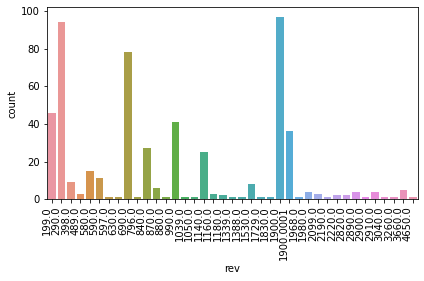

In [6]:
ax = sns.countplot(x='rev', data=bills)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

In [12]:
bills.merge(active_students, how='inner', on='student_id')

,student_id,rev
0,1627,990.0000
1,100300,990.0000
2,108270,290.0000
3,264473,1900.0001
4,274352,690.0000
...,...,...
387,5645737,1900.0000
388,5651566,1900.0000
389,5662322,1900.0000
390,5681918,1900.0000


In [15]:
bills.merge(active_students, how='inner', on='student_id').rev.sum()

467794.0035

Кхм. Только 392 человека из 541 заплативших числятся активными, это 70% клиентов, хотя 80% денег. Тем не менее, если 20% доходов сервиса приходит от людей, не задействованных в сервисе, то неплохо бы поисследовать происходящее, и либо эксплуатировать ситуацию дальше, либо хотя бы понимать, когда и с какой вероятностью эти 20% пропадут.

Конечно, с подавляющей вероятностью нужно просто пересмотреть определение "активного пользователя". Описание дано какое-то мутное, данных нет, так что здесь это сделать не получится.

Про метрики. На что вообще, в теории, было бы интересно посмотреть: arpu, cr, aov, return rate, profit. Видимо, отдельно для активных и для всех пользователей, пока не разобрались с тем, что 20% бабла прилетает из космоса. А уже по результатам разборок выбирать метрику, которая действительно интересует.

При этом, даже озвученное -- десять метрик, и все мы знаем, что если очень пристально смотреть в данные, то результаты всегда можно найти. Поэтому я пренебрегу cr и aov: в первую очередь наверняка интересует итоговое бабло на человека, а не то, куда он там кликал в процессе (unless именно на это ставился эксперимент, но этого в постановке нет).

Return rate на этих данных не посчитать, и я не знаю бизнес-модель и применимость метрики вообще. Но в целом эти вот "восхитительные новые формы" могут заставить человека заплатить за то, чего он вообще не хотел, испортить лояльность и уменьшить профит на большом горизонте. В зависимости от периода возврата, эксперимент на сравнение rr может быть вообще нецелесообразен, но опять же, бизнес-модель.

Profit -- это про то, сколько было заработано, а не сколько было продано. Если новая форма промотирует товары, с которых компания не получает бабла, за счёт товаров, с которых получает, то rpu может и вырасти, но это не очень поможет. Больше применимо к стандартному екому, чем к продаже интеллектуальной собственности, но и тут могут быть проблемные механизмы. На этих данных, конечно, не посчитать.

Это были четыре параграфа на тему "я посчитаю только arpu & arpau". Предполагаем t тест с p = 0.05. Измеряем всего две метрики, так что поправка Бонферрони не так сильно гасит p, считаем границей принятия гипотезы p = 0.025.

Считаем для arpu

In [21]:
revs_segments = segments.merge(bills, how='left', left_on='id', right_on='student_id')

In [22]:
len(revs_segments[bills_segments.rev.notnull()]) # typo check

541

In [24]:
revs_segments = revs_segments[['grp', 'rev']].fillna(0)

In [31]:
a_data = revs_segments[revs_segments.grp == 'A'].rev
b_data = revs_segments[revs_segments.grp == 'B'].rev
arpu_ttest = ttest_ind(a_data, b_data)
arpu_ttest

Ttest_indResult(statistic=-1.7316948135436543, pvalue=0.08333204995973237)

In [30]:
a_data.std(), b_data.std() # welch vs student check, student is ok

(100.79084860984236, 113.24999849975491)

In [32]:
revs_segments = segments.merge(bills, how='left', left_on='id', right_on='student_id')
revs_segments = revs_segments.merge(active_students, how='inner', left_on='id', right_on='student_id')
revs_segments

,id,grp,student_id_x,rev,student_id_y
0,946259,B,NaN,NaN,946259
1,1896859,B,NaN,NaN,1896859
2,938570,A,NaN,NaN,938570
3,4808409,B,NaN,NaN,4808409
4,3242161,B,NaN,NaN,3242161
...,...,...,...,...,...
8336,1524221,B,NaN,NaN,1524221
8337,1302888,A,NaN,NaN,1302888
8338,1778339,B,NaN,NaN,1778339
8339,1138474,A,NaN,NaN,1138474


In [33]:
revs_segments = revs_segments[['grp', 'rev']].fillna(0)

a_data = revs_segments[revs_segments.grp == 'A'].rev
b_data = revs_segments[revs_segments.grp == 'B'].rev
arpau_ttest = ttest_ind(a_data, b_data)
arpau_ttest

Ttest_indResult(statistic=-1.225341107379344, pvalue=0.22048133326988403)

In [34]:
a_data.std(), b_data.std() # welch vs student check, student is ok

(290.49063178049346, 313.77020063793975)

Ну и конец разговора, в принципе, остаёмся на старой форме. Аккуратная формулировка, мы не можем отвергнуть гипотезу о том, что для новой формы arpu не отличается от arpu старой.

Не отменяет, что с активностью нужно разобраться, она точно где-то ещё выплывет.

Эмм, там в плане был ещё вопрос "имеются ли различия в показателях и с чем они могут быть связаны?"

Я сомневаюсь, что существует разбиение данных выше на группы такое, что arpu строго одинаково для двух групп. Случайность, статистика, все дела